In [1]:
import sys
import os
sys.path.insert(0,f'/Users/{os.environ["USERNAME"]}/Documents/DS/Crypto')
from Twitter.connector import connect_remote_sql_alchemy

In [2]:
import matplotlib.pyplot as plt
import sqlite3
from pyproj import Transformer
import json
import pandas as pd
from datetime import datetime

In [3]:
conn = connect_remote_sql_alchemy()

In [4]:
# f"SELECT id, price, processing_date FROM yad2_forsale_history where id in"
#                  f" (select id from yad2_forsale_history where processing_date = '{datetime.today().strftime('%Y%m%d')}' or"
#                  f" processing_date = '{(datetime.today() - pd.to_timedelta('1D')).strftime('%Y%m%d')}')"

# df = pd.read_sql("SELECT id, price, processing_date FROM yad2_history", conn)

df_hist = pd.read_sql("select id, price, processing_date from yad2_forsale_history", conn)
print(df_hist.groupby('processing_date').size())

processing_date
2023-01-21    43872
2023-01-22     8303
2023-01-23     1555
2023-01-24     1164
2023-01-25     1360
2023-01-26     5272
2023-01-27     4498
2023-01-28     4759
2023-01-29     6022
2023-01-30     5820
2023-01-31     5808
2023-02-01     5757
2023-02-02     5550
2023-02-03     5000
2023-02-04     4672
2023-02-05     5986
2023-02-06     5896
2023-02-07     5775
2023-02-08     5869
2023-02-09     5655
2023-02-10     5768
2023-02-11     4743
dtype: int64


In [78]:
info_cols = ['id', 'row_2', 'row_1', 'line_1', 'square_meters', 'line_2', 'neighborhood', 'merchant', 'assetclassificationid_text', 'coordinates', 'feed_source', 'address_more', 'search_text', 'date_added', 'date_updated']
df_today = pd.read_sql(f"Select {','.join(info_cols)} from yad2_today", conn)
print("Fetched rows:",len(df_today))

Fetched rows: 60801


In [79]:
# df_hist.to_pickle('resources/yad2_df_hist.pk')
# df_today.to_pickle('resources/yad2_df_today.pk')

In [80]:
# pd.read_sql(f"Select * from yad2_today limit 10", conn) # [['merchant', 'merchant_name']] # .columns # ['row_4']

In [81]:
df_today = df_today[~df_today['id'].duplicated()]
print("After rem dup:", len(df_today))

After rem dup: 54419


<AxesSubplot: xlabel='date_added'>

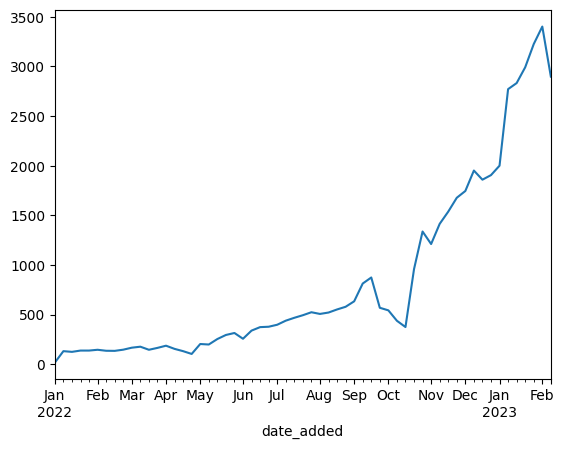

In [82]:
pd.to_datetime(df_today['date_added']).where(lambda x : x > pd.to_datetime('2022-01-01')).to_frame().set_index('date_added').resample('W').size().plot()

In [83]:
info_rename = dict(row_2='city', row_1='street', line_1='rooms', line_2='floor', assetclassificationid_text='status', search_text='info_text')
df_today['is_agency'] = df_today['feed_source'].apply(lambda x: True if x == 'commercial' else False if x == 'private' else None)
df_today = df_today.set_index('id').rename(columns=info_rename)
df_today['coordinates'] = df_today['coordinates'].apply(lambda x: json.loads(x.replace("'",'"')))
df_today['info_text'] = df_today['info_text'].apply(lambda x: x.split('תאור לקוח')[1] if len(x.split('תאור לקוח')) > 1 else None )

df_today['floor'] = df_today['floor'].apply(lambda x: 0 if x == 'קומת קרקע' else x.split(' ')[1].replace('-','')).astype(int)
df_today['rooms'] = df_today['rooms'].apply(lambda x: None if x == 'לא צויינו חדרים' else '1' if x == 'חדר אחד' else x.split(' ')[0]).astype(float)
df_today['type'] = df_today['city'].apply(lambda x: x.split(',')[0])
df_today['city_loc'] = df_today['city'].apply(lambda x: ','.join(x.split(',')[1:-1]))
df_today['city'] = df_today['city'].apply(lambda x: x.split(',')[-1])
df_today['lat'] = df_today['coordinates'].apply(lambda x: x.get('latitude'))
df_today['long'] = df_today['coordinates'].apply(lambda x: x.get('longitude'))

In [128]:
cols_order = ['type', 'city', 'city_loc', 'rooms', 'square_meters', 'floor',
       'status', 'is_agency', 'neighborhood', 'street',
       'address_more', 'info_text', 'date_added',  'lat', 'long', 'coordinates']

In [86]:
df_today = df_today[cols_order]

In [89]:
df_today.head()

,type,city,city_loc,rooms,square_meters,neighborhood,floor,status,is_agency,street,address_more,info_text,date_added,lat,long,coordinates
id,,,,,,,,,,,,,,,,
sqovkhqg,דירה,תל אביב יפו,נווה אביבים,4.5,145.0,נווה אביבים,4,דרוש שיפוץ,True,נווה אביבים,חדשה בשוק!!!,"בנווה אביבים, ברחוב לויטן במיקום מעולה במרכז...",2022-11-24 12:40:41,32.117652,34.797324,"{'latitude': 32.117652, 'longitude': 34.797324}"
03osn0l8,דירה,ערד,,4.0,95.0,nan,6,משופץ,True,אלעזר בן יאיר,4 חד מעלית מיזוג מידי,4 חד שמורה מתאימה למגורים וגם להשכעה 4 חד מעל...,2023-02-02 16:57:31,31.258166,35.209296,"{'latitude': 31.2581661643836, 'longitude': 35..."
qy17lshe,בית פרטי/קוטג',זכרון יעקב,גבעת עדן,6.0,215.0,גבעת עדן,0,משופץ,True,גבעת עדן,None,למכירה בגבעת עדן המבוקשת- בפרויקט טוסקנה .\nק...,2023-01-19 10:19:02,32.586056,34.950434,"{'latitude': 32.586056, 'longitude': 34.950434}"
vtv2hc0t,דירה,ראשון לציון,ראשונים,5.0,130.0,ראשונים,4,דרוש שיפוץ,False,טיומקין 19,None,"מפרטי, ללא תיווך - דירה מתוקה בבניין מקסים ב...",2023-01-30 18:52:18,31.957828,34.803915,"{'latitude': 31.957828, 'longitude': 34.803915}"
mgu2c3ae,דירה,הרצליה,"הרצליה הירוקה, נווה עובד",4.0,100.0,"הרצליה הירוקה, נווה עובד",2,חדש מקבלן (לא גרו בנכס),True,"הרצליה הירוקה, נווה עובד",בשכונה חדשה במערב הרצליה,סנצ'ורי 21 - \nדירה חדשה שבנייתה הסתיימה זה ע...,2022-07-26 12:19:40,32.170703,34.840096,"{'latitude': 32.170703, 'longitude': 34.840096}"


In [90]:
df_hist = df_hist.dropna()
df_hist['price'] = df_hist['price'].astype(int)
# pd.options.display.float_format = '{:,.2f}'.format
df_hist = df_hist.drop_duplicates()

In [91]:
print(len(df_hist))
df = df_hist[df_hist['id'].isin(df_today.index)] # filter only to available ids
print(len(df))

72865
57342


In [92]:
df_p = df.pivot(index='id', columns='processing_date', values='price')
df_p = df_p.ffill(axis=1).bfill(axis=1)

In [93]:
# ids[ids >3]

In [94]:
ids = df_hist.groupby('id').size()
ids = ids[ids > 1]
# ids.index

In [95]:
price_hist = df_hist[df_hist['id'].isin(ids.index)].sort_values(['id', 'processing_date']).groupby('id').agg(dict(price=list, processing_date=list))
price_hist.columns = ['price_hist', 'dt_hist']

In [96]:
# TODO: THIS IS BETTER FOR NOT HAVING FFILL AND BFILL for handling nulls
# df_p.apply(lambda x: (x[x.last_valid_index()] / x[x.first_valid_index()]) -1, axis=1).rename('price_pct')

In [97]:
price_pct = df_p.apply(lambda x: (x[-1] / x[0]) -1, axis=1).rename('price_pct')
price_diff = df_p.apply(lambda x: x[0] - x[-1], axis=1).rename('price_diff')
first_price = df_p.apply(lambda x: x[0], axis=1).rename('first_price')
last_price = df_p.apply(lambda x: x[-1], axis=1).rename('last_price')

In [98]:
df_metrics = pd.concat([first_price, last_price, price_diff, price_pct, price_hist], axis=1)

In [99]:
df_metrics.loc['01gxh9ad']

first_price                   1620000.0
last_price                    1590000.0
price_diff                      30000.0
price_pct                     -0.018519
price_hist           [1620000, 1590000]
dt_hist        [2023-01-22, 2023-02-08]
Name: 01gxh9ad, dtype: object

In [100]:
df = pd.concat([df_metrics, df_today[~df_today.index.duplicated()]], axis=1)

In [101]:
# df

In [103]:
df[df['price_pct'] < 0] # .sort_values()

,first_price,last_price,price_diff,price_pct,price_hist,dt_hist,type,city,city_loc,rooms,...,floor,status,is_agency,street,address_more,info_text,date_added,lat,long,coordinates
id,,,,,,,,,,,,,,,,,,,,,
00n1qqk8,7200000.0,7150000.0,50000.0,-0.006944,"[7200000, 7150000]","[2023-01-21, 2023-01-30]",בית פרטי/קוטג',אור יהודה,,12.5,...,0.0,משופץ,True,אור יהודה,דו משפחתי נמכר יחד 2 יחידות!!!,דו משפחתי פינתי למכירה \nמחולק ל4 עם חצר גדו...,2022-10-11 13:32:27,32.028492,34.857832,"{'latitude': 32.028492, 'longitude': 34.857832}"
00yhxszq,3100000.0,3000000.0,100000.0,-0.032258,"[3100000, 3000000]","[2023-01-21, 2023-02-01]",דירה,ראש העין,פסגות אפק,5.0,...,1.0,חדש (גרו בנכס),False,נאדין גורדימר 9,None,"בפרויקט האיכותי של פרשקובסקי, דירה גדולה ומרו...",2023-01-12 14:01:20,32.083268,34.962268,"{'latitude': 32.083268, 'longitude': 34.962268}"
01gxh9ad,1620000.0,1590000.0,30000.0,-0.018519,"[1620000, 1590000]","[2023-01-22, 2023-02-08]",דירה,חיפה,קרית חיים מזרחית,3.0,...,1.0,חדש (גרו בנכס),True,קרית חיים מזרחית,3 חדרים חדשה באחריות קבלן אזור מבוקש,בבניין מפואר אשר אוכלס לפני שנה במיקום מנצח ו...,2023-01-19 15:33:43,32.822519,35.070471,"{'latitude': 32.822519, 'longitude': 35.070471}"
01h2rpwz,1890000.0,1850000.0,40000.0,-0.021164,"[1890000, 1850000]","[2023-02-08, 2023-02-09]",דירה,קרית גת,כרמי גת,4.0,...,5.0,חדש (גרו בנכס),False,נחל ירקון 46,None,"הזדמנות מעולה! 50 אש""ח מתחת למחיר השוק.\n\nדי...",2023-02-07 10:21:51,31.628025,34.770424,"{'latitude': 31.628025, 'longitude': 34.770424}"
01pikl3a,5850000.0,5650000.0,200000.0,-0.034188,"[5850000, 5650000]","[2023-01-21, 2023-01-24]",בית פרטי/קוטג',יהוד מונוסון,,5.5,...,0.0,משופץ,True,יהוד מונוסון,None,דו משפחתי מקסים ומטופח. במיקום שקט וקרוב לכל ...,2023-01-16 17:30:55,32.029254,34.879627,"{'latitude': 32.029254, 'longitude': 34.879627}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzcgzwmv,1520000.0,1490000.0,30000.0,-0.019737,"[1520000, 1490000]","[2023-01-21, 2023-01-24]",דירה,אשקלון,נווה אילן,4.0,...,4.0,משופץ,True,נווה אילן,נוף לפארק,"דירה מהממת באזור מושלם, יש * ממד * מרפסת לפאר...",2023-01-06 10:38:34,31.666614,34.579157,"{'latitude': 31.666614, 'longitude': 34.579157}"
zzib4jof,5100000.0,4800000.0,300000.0,-0.058824,"[5100000, 4800000]","[2023-01-29, 2023-01-31]",דירה,תל אביב יפו,רמת אביב ג',4.0,...,2.0,במצב שמור,True,רמת אביב ג',ליד מרכז שוסטר. שקטה,דירה שקטה ליד מרכז שוסטר. חדרים מרווחים. נוף ...,2022-10-14 21:04:22,32.126064,34.802278,"{'latitude': 32.126064, 'longitude': 34.802278}"
zzkvylel,1700000.0,1690000.0,10000.0,-0.005882,"[1700000, 1690000]","[2023-01-21, 2023-01-22]",דירה,חיפה,"נעמ""ת",4.0,...,2.0,במצב שמור,True,שמשון,None,"נהדרת! דירה גדולה! בודדה בקומה, ארבעה כווני א...",2022-12-05 18:47:33,32.795894,34.989289,"{'latitude': 32.7958939428571, 'longitude': 34..."


In [104]:
df.query('last_price < 3000000 and -0.9 < price_pct < -0.01 and price_diff < 1e7').sort_values('price_pct')
# df.query('price_pct < -0.01').sort_values('price_pct')
# df.sort_values('price_pct')

,first_price,last_price,price_diff,price_pct,price_hist,dt_hist,type,city,city_loc,rooms,...,floor,status,is_agency,street,address_more,info_text,date_added,lat,long,coordinates
id,,,,,,,,,,,,,,,,,,,,,
u4lpught,4400000.0,2500000.0,1900000.0,-0.431818,"[4400000, 2500000]","[2023-01-21, 2023-02-10]",בית פרטי/קוטג',גן יבנה,גן יבנה מערב,5.0,...,0.0,חדש (גרו בנכס),False,רחל המשוררת 1,None,"מגרש, קרקע לבניית יחידה אחרונה בפרויקט יוקרתי...",2022-12-30 13:20:24,31.790902,34.701631,"{'latitude': 31.790902, 'longitude': 34.701631}"
b9buah4b,3950000.0,2875000.0,1075000.0,-0.272152,"[3950000, 2875000]","[2023-01-23, 2023-02-03]",דירה,הרצליה,,4.0,...,3.0,במצב שמור,True,הרצליה,חניה בהסכמה,מצויינת למשקיעים/זוגות צעירים\nדירת 4 חד \nחנ...,2023-01-23 09:50:21,32.166778,34.842806,"{'latitude': 32.166778, 'longitude': 34.842806}"
2lbj0nje,1500000.0,1100000.0,400000.0,-0.266667,"[1500000, 1100000]","[2023-02-05, 2023-02-08]",דירה,תל אביב יפו,הצפון הישן - דרום,1.0,...,0.0,משופץ,False,דיזנגוף 119,בדיזינגוף דירת חדר משופצת קומת קרקע עם גינה,"מפרטי ללא עמלת תיווך, בלב המדינה במיקום הכי מ...",2023-02-05 11:00:16,32.080922,34.773599,"{'latitude': 32.080922, 'longitude': 34.773599}"
vld5cxmx,1350000.0,990000.0,360000.0,-0.266667,"[1350000, 1080000, 990000]","[2023-01-21, 2023-01-25, 2023-02-04]",דירה,חיפה,קרית חיים מזרחית,3.0,...,1.0,במצב שמור,True,אהרון צייטלין 20,חנייה בשפע,חדש למכירה בשיווק בלעדי.\nמשקיעים שימו לב.\nד...,2022-12-30 19:09:04,32.817475,35.068930,"{'latitude': 32.817475, 'longitude': 35.06893}"
cl39yw9b,3100000.0,2300000.0,800000.0,-0.258065,"[3100000, 2300000]","[2023-01-21, 2023-01-31]",דירה,תל אביב יפו,"צהלון, שיכוני חסכון",3.5,...,0.0,במצב שמור,True,"ציהתל""י 57",יש חצר ענקית בהסכמה לא בטאבו,במיקום מעולה בלב יפו מיועדת לפינוי בינוי \nדי...,2022-12-20 11:31:16,32.038736,34.754927,"{'latitude': 32.038736, 'longitude': 34.754927}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ep17ylq6,2990000.0,2960000.0,30000.0,-0.010033,"[2990000, 2960000]","[2023-01-31, 2023-02-02]",דירה,יהוד מונוסון,ליבת העיר,5.0,...,3.0,חדש (גרו בנכס),True,דרך העצמאות,דירת חמישה חדרים הזדמנות לכניסה מהירה,למכירה דירת 5 חדרים ברחוב העצמאות\nבניין חדש ...,2022-10-23 19:41:47,32.027863,34.888157,"{'latitude': 32.0278627567567, 'longitude': 34..."
wgwcisjt,1995000.0,1975000.0,20000.0,-0.010025,"[1995000, 1975000]","[2023-01-21, 2023-02-06]",דירה,ראשון לציון,"רמב""ם",3.5,...,4.0,משופץ,True,בית יוסף,מעלית וחניה בטאבו!!,"בשכונת רמב""ם רחוב חד סיטרי שקט מאוד !! דירת 3...",2022-10-26 09:38:04,31.964107,34.814274,"{'latitude': 31.9641070909091, 'longitude': 34..."
n928o2j0,3000000.0,2970000.0,30000.0,-0.010000,"[3000000, 2970000]","[2023-01-21, 2023-01-30]",דירה,רעננה,,4.0,...,1.0,משופץ,True,אלימלך רימלט,None,חדש חדש . דירת 4 חדרים עברה שיפוץ כללי כולל ה...,2022-08-11 18:54:14,32.195521,34.850123,"{'latitude': 32.1955205517241, 'longitude': 34..."


In [105]:
# https://www.yad2.co.il/item/rsecw38q

In [106]:
df.loc['rsecw38q']

first_price                                              2990000.0
last_price                                               2550000.0
price_diff                                                440000.0
price_pct                                                -0.147157
price_hist                                      [2990000, 2550000]
dt_hist                                   [2023-01-21, 2023-01-24]
type                                                          דירה
city                                                         נתניה
city_loc                                            מרכז העיר דרום
rooms                                                          4.0
square_meters                                                130.0
neighborhood                                        מרכז העיר דרום
floor                                                          5.0
status                                                   במצב שמור
is_agency                                                     

In [107]:
df.query('last_price < 3000000 and -0.9 < price_pct < -0.01 and price_diff < 1e7').sort_values('price_pct').head()

,first_price,last_price,price_diff,price_pct,price_hist,dt_hist,type,city,city_loc,rooms,...,floor,status,is_agency,street,address_more,info_text,date_added,lat,long,coordinates
id,,,,,,,,,,,,,,,,,,,,,
u4lpught,4400000.0,2500000.0,1900000.0,-0.431818,"[4400000, 2500000]","[2023-01-21, 2023-02-10]",בית פרטי/קוטג',גן יבנה,גן יבנה מערב,5.0,...,0.0,חדש (גרו בנכס),False,רחל המשוררת 1,None,"מגרש, קרקע לבניית יחידה אחרונה בפרויקט יוקרתי...",2022-12-30 13:20:24,31.790902,34.701631,"{'latitude': 31.790902, 'longitude': 34.701631}"
b9buah4b,3950000.0,2875000.0,1075000.0,-0.272152,"[3950000, 2875000]","[2023-01-23, 2023-02-03]",דירה,הרצליה,,4.0,...,3.0,במצב שמור,True,הרצליה,חניה בהסכמה,מצויינת למשקיעים/זוגות צעירים\nדירת 4 חד \nחנ...,2023-01-23 09:50:21,32.166778,34.842806,"{'latitude': 32.166778, 'longitude': 34.842806}"
2lbj0nje,1500000.0,1100000.0,400000.0,-0.266667,"[1500000, 1100000]","[2023-02-05, 2023-02-08]",דירה,תל אביב יפו,הצפון הישן - דרום,1.0,...,0.0,משופץ,False,דיזנגוף 119,בדיזינגוף דירת חדר משופצת קומת קרקע עם גינה,"מפרטי ללא עמלת תיווך, בלב המדינה במיקום הכי מ...",2023-02-05 11:00:16,32.080922,34.773599,"{'latitude': 32.080922, 'longitude': 34.773599}"
vld5cxmx,1350000.0,990000.0,360000.0,-0.266667,"[1350000, 1080000, 990000]","[2023-01-21, 2023-01-25, 2023-02-04]",דירה,חיפה,קרית חיים מזרחית,3.0,...,1.0,במצב שמור,True,אהרון צייטלין 20,חנייה בשפע,חדש למכירה בשיווק בלעדי.\nמשקיעים שימו לב.\nד...,2022-12-30 19:09:04,32.817475,35.068930,"{'latitude': 32.817475, 'longitude': 35.06893}"
cl39yw9b,3100000.0,2300000.0,800000.0,-0.258065,"[3100000, 2300000]","[2023-01-21, 2023-01-31]",דירה,תל אביב יפו,"צהלון, שיכוני חסכון",3.5,...,0.0,במצב שמור,True,"ציהתל""י 57",יש חצר ענקית בהסכמה לא בטאבו,במיקום מעולה בלב יפו מיועדת לפינוי בינוי \nדי...,2022-12-20 11:31:16,32.038736,34.754927,"{'latitude': 32.038736, 'longitude': 34.754927}"


In [108]:
df.loc['ojtkf58r'] # ['info_text']

first_price                                              1135000.0
last_price                                               1235000.0
price_diff                                               -100000.0
price_pct                                                 0.088106
price_hist                    [1135000, 1155000, 1225000, 1235000]
dt_hist           [2023-01-21, 2023-01-26, 2023-01-29, 2023-01-31]
type                                                          דירה
city                                                       באר שבע
city_loc                                                 שכונה י"א
rooms                                                          4.5
square_meters                                                101.0
neighborhood                                             שכונה י"א
floor                                                          1.0
status                                                       משופץ
is_agency                                                    F

In [109]:
df['price_hist']

id
000lge5g    [2700000, 2750000, 2800000]
001hfol0                            NaN
001hv94y                            NaN
0021e7ng                            NaN
003iem8d                            NaN
                       ...             
wiiyrpt4                            NaN
fv5ma67f                            NaN
a9m0dcrw                            NaN
jjnptsrv                            NaN
0cw8yygx                            NaN
Name: price_hist, Length: 55292, dtype: object

In [110]:
df[df['price_hist'].apply(lambda x: len(x) if isinstance(x, list) else 0) >= 3].dropna(subset='last_price').sort_values('price_pct', ascending=False)[10:]

,first_price,last_price,price_diff,price_pct,price_hist,dt_hist,type,city,city_loc,rooms,...,floor,status,is_agency,street,address_more,info_text,date_added,lat,long,coordinates
id,,,,,,,,,,,,,,,,,,,,,
i8354d5f,3.500000e+06,3950000.0,-4.500000e+05,0.128571,"[3500000, 3800000, 3950000]","[2023-01-21, 2023-01-22, 2023-01-23]",גג/פנטהאוז,טבריה,שיכון עובדים,5.5,...,10.0,חדש (גרו בנכס),False,מורן 14,None,"פנטהאוז יוקרתי בשלושה מפלסים, קומה ראשונה סלו...",2022-03-08 20:46:46,32.799881,35.518551,"{'latitude': 32.799881, 'longitude': 35.518551}"
qcvw7lfe,7.100000e+06,8000000.0,-9.000000e+05,0.126761,"[7100000, 6100000, 8000000]","[2023-01-21, 2023-01-22, 2023-02-09]",דירה,תל אביב יפו,"גני שרונה, קרית הממשלה",5.0,...,20.0,חדש מקבלן (לא גרו בנכס),False,אוסוולדו ארניה 2,None,הערכת שמאי עדכנית 1 9 מיליון.\r\nבמגדלי בסר ...,2022-11-12 11:50:23,32.073147,34.786051,"{'latitude': 32.073147, 'longitude': 34.786051}"
lzoju8xi,3.700000e+06,4100000.0,-4.000000e+05,0.108108,"[3700000, 3500000, 4100000]","[2023-01-22, 2023-01-29, 2023-02-08]",בית פרטי/קוטג',נתיבות,נתיבות מערב,5.0,...,0.0,חדש (גרו בנכס),False,כפר דרום 15,None,וילה באזור יוקרתי עם open space מטורף \nבמטב...,2022-02-25 12:42:25,31.419452,34.567526,"{'latitude': 31.419452, 'longitude': 34.567526}"
tiiz1ax0,3.700000e+06,4100000.0,-4.000000e+05,0.108108,"[3700000, 4200000, 3800000, 4100000]","[2023-01-21, 2023-01-30, 2023-02-06, 2023-02-08]",דירה,תל אביב יפו,"מונטיפיורי, הרכבת",3.0,...,33.0,חדש (גרו בנכס),True,דרך מנחם בגין 144,MIDTOWN TLV | משורר השקעות,למכירה במגדל MIDTOWN TLV !\nדירת 3 חדרים כ - ...,2022-12-08 14:25:46,32.077662,34.793063,"{'latitude': 32.077662, 'longitude': 34.793063}"
raivy02m,4.595000e+06,5075000.0,-4.800000e+05,0.104461,"[4595000, 5150000, 5075000]","[2023-01-21, 2023-02-03, 2023-02-08]",גג/פנטהאוז,בת ים,"דרום חדש, פארק הים",5.0,...,29.0,חדש (גרו בנכס),False,נעמי שמר 6,None,דירת מיני פנטהאוז בצמרת המגדל! \r\nקו ראשון ל...,2023-01-12 00:42:25,32.006530,34.740614,"{'latitude': 32.00653, 'longitude': 34.740614}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2y33r22x,1.390000e+07,7500000.0,6.400000e+06,-0.460432,"[13900000, 6500000, 7500000]","[2023-01-23, 2023-01-26, 2023-02-03]",משק חקלאי/נחלה,מגדים,,NaN,...,0.0,במצב שמור,True,מגדים,None,"נחלה יפה !\nמיקום שקט וטוב\n3.5 חלקה צהובה ,...",2023-01-22 21:23:23,32.729022,34.959158,"{'latitude': 32.729022, 'longitude': 34.959158}"
rpmntjz0,4.800000e+07,4690000.0,4.331000e+07,-0.902292,"[48000000, 4750000, 4690000]","[2023-01-21, 2023-01-22, 2023-02-08]",גג/פנטהאוז,פתח תקווה,כפר גנים ג,5.0,...,8.0,חדש (גרו בנכס),True,יפה נוף,None,מני פנטהאוז מרהיב ביופיו דירת 5 חד שהפכו ל4 ג...,2023-01-20 11:58:04,32.076842,34.862685,"{'latitude': 32.0768416346154, 'longitude': 34..."
n7hkipyd,2.700000e+06,100000.0,2.600000e+06,-0.962963,"[2700000, 2600000, 100000]","[2023-02-01, 2023-02-05, 2023-02-09]",דירה,תל אביב יפו,נווה שרת,2.0,...,3.0,משופץ,False,בית אל 5,None,"דירה מיוחדת*מוארת*לא בבניין ""רכבת""\n*קרובה לכ...",2023-01-31 23:39:10,32.118479,34.838596,"{'latitude': 32.118479, 'longitude': 34.838596}"


In [111]:
import numpy as np
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1 = np.radians([lat1, lon1])
        lat2, lon2 = np.radians([lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))
def calc_dist(df, deal, distance):
    dist = haversine(df['lat'], df['long'], deal['lat'], deal['long'])
    df['dist'] = dist
    df = df[df['dist'] < distance]
    return df

In [112]:
con_taxes = sqlite3.connect('resources/nadlan.db')

In [113]:
def get_similar_closed_deals(deal, days_back, dist_km, with_room):
    if np.isnan(deal['lat']) or np.isnan(deal['long']):
        raise ValueError('lat or long are not valid')
    wgs84_itm_to_trans = Transformer.from_crs(4326, 2039)
    cor_x, cor_y = wgs84_itm_to_trans.transform(deal['lat'], deal['long'])
    # print(cor_x, cor_y)
    dt_back = (datetime.today() - pd.to_timedelta(f'{days_back}D')).strftime('%Y%m%d')
    sql_dist_cond = f'and sqrt((pow(corX - {cor_x}, 2) + pow(corY - {cor_y}, 2))/1000000)'
    sql_room_cond = f"and round(misHadarim) = round({deal['rooms']})" if with_room else ""
    q = f'select {sql_dist_cond.split("and")[1]} as dist_from_deal, *  from trans where tariska > {dt_back}' \
        f' {sql_dist_cond} < {dist_km}'\
        f' {sql_room_cond}'\
        f' and helekNimkar = 1.0'
    # print(q)
    df_tax = pd.read_sql(q, con_taxes)
    return df_tax

def plot_deal_vs_sale_sold(other_close_deals, df_tax, deal):
    # When the hist becomes square thats because there a huge anomaly in terms of extreme value
    sale_items = other_close_deals[other_close_deals['rooms'] == deal['rooms']]['last_price']
    sale_items.rename(f'last_price #{len(sale_items)}').hist(bins=min(70, len(sale_items)), legend=True, alpha=0.8)
    sold_items = df_tax['mcirMorach']
    if len(sold_items):
        sold_items.rename(f'realPrice{days_back}D #{len(sold_items)}').hist(bins=min(70, len(sold_items)), legend=True, alpha=0.8)
    plt.axvline(deal['last_price'], color='red', label=f"{deal['last_price']:,.0f}", linewidth=2)
    str_txt = f"{'חדרים'[::-1]} {deal['rooms']},{deal['type'][::-1]}, {deal['street'][::-1]}, {deal['city'][::-1]}, {deal['price_pct']:0.2%}"
    plt.xlim([deal['last_price'] // 2, deal['last_price'] * 3])
    plt.title(str_txt)
    plt.legend()
    plt.show()

In [114]:
deal_id = np.random.choice(df[df['price_pct'] < 0].index)
# deal_id = 'yu16k5yx'
# deal_id = 'zct9jz2a'
# deal_id = 'vgnsg6pf'
# deal_id = 'omresoki'
assert deal_id in df.index

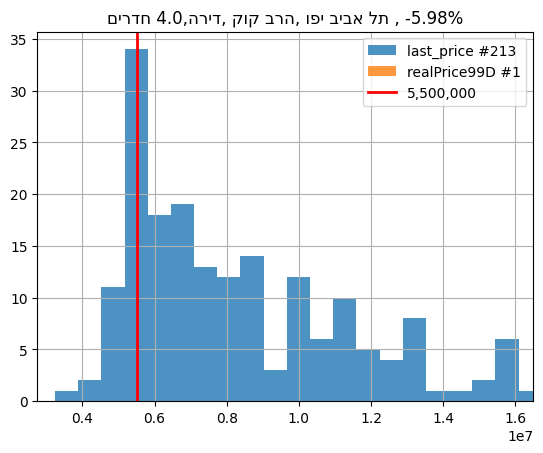

 4 חדרים 92 מ"ר נטו + מרפסת שמש גדולה 35 מר מהסלון + מרפסת שמש מחדר השינה , שירותים ומקלחת כפולים , בניין לשימור שעבר חידוש , מעלית וחניה בטאבו תיקרה גבוה 3.3 מ מיקום מעולה בבניין חדיש שעבר שימור סוקולוב נכסים הינו משרד תיווך דירות הפועל ברציפות למעלה מ-29 שנים , במתן דגש על ליווי ושירות מהטובים שיש בתחום, אמינות ומקצועיות , בכל הרשור להערכת נכסים ומכירתם , יזמויות ואיתור השקעות מניבות . סוכנות סוקולוב נכסים 


97

,dist_from_deal,ezor,gush,tarIska,yeshuv,rechov,bayit,knisa,dira,mcirMozhar,...,tifkudBnyn,tifkudYchida,shumaHalakim,mofaGush,tava,mahutZchut,helekNimkar,corX,corY,insertionDate
0,0.521335,50 - מק-תל אביב,007002-0037-232-00,20221122,תל אביב -יפו,הירקון,2,--,232,44071425,...,מגורים,דירה בבית קומות,1 / 1 ליחידה בשלמותה,0,--,בעלות כפופה לחכירה,1.0,177866,663839,2023-01-13 16:01:52.978786


,first_price,last_price,price_diff,price_pct,price_hist,dt_hist,type,city,city_loc,rooms,...,status,is_agency,street,address_more,info_text,date_added,lat,long,coordinates,dist
id,,,,,,,,,,,,,,,,,,,,,
q9gj85x4,30000.0,30000.0,0.0,0.0000,NaN,NaN,בית פרטי/קוטג',תל אביב יפו,נווה צדק,4.0,...,במצב שמור,True,נווה צדק,בהזדמנות ליזמים במיקום מבוקש בית+מגרש לבניה רוויה,עסקה מעניינת ליזמים / קבלנים!!! במיקום נדיר ו...,2022-12-19 21:47:16,32.063260,34.763762,"{'latitude': 32.06326, 'longitude': 34.763762}",0.924260
kaowwtqu,2400000.0,2250000.0,150000.0,-0.0625,"[2400000, 2250000]","[2023-01-21, 2023-01-22]",דירה,תל אביב יפו,,4.0,...,במצב שמור,True,טשרניחובסקי,בלב ת''א,"למכירה נכס מסחרי בקומת מרתף, \nבמיקום הכי מבו...",2022-05-15 13:28:28,32.073304,34.772138,"{'latitude': 32.0733041132075, 'longitude': 34...",0.578726
l50j5to8,3600000.0,3600000.0,0.0,0.0000,NaN,NaN,דירה,תל אביב יפו,הצפון הישן - דרום,4.0,...,במצב שמור,True,המליץ,None,דירה גדולה\r\nמחיר מעולה\r\nלשיפוץ סוכנות נכס...,2020-06-25 10:03:25,32.074857,34.774261,"{'latitude': 32.074857, 'longitude': 34.774261}",0.834549
zssjyau0,3900000.0,3900000.0,0.0,0.0000,NaN,NaN,דירה,תל אביב יפו,כרם התימנים,4.0,...,משופץ,False,הרב אהרונסון 31,None,דירה בדמי מפתח\n4 חדרים גדולים \n200 מטר מהים,2022-08-10 19:38:05,32.070690,34.766595,"{'latitude': 32.07069, 'longitude': 34.766595}",0.062030
w77k2u5q,4500000.0,4500000.0,0.0,0.0000,NaN,NaN,דירה,תל אביב יפו,"לב תל אביב, לב העיר צפון",4.0,...,משופץ,True,"לב תל אביב, לב העיר צפון",None,בלב העיר! בקרבת שד' רוטשילד!\nדירת 4 חדרים מר...,2023-01-15 12:51:56,32.070137,34.773903,"{'latitude': 32.070137, 'longitude': 34.773903}",0.708378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zkowwydi,30000000.0,30000000.0,0.0,0.0000,NaN,NaN,גג/פנטהאוז,תל אביב יפו,,4.0,...,חדש (גרו בנכס),True,רציף הרברט סמואל,None,פנינת הים -פנטאהוז -4 חדרים +משרד-בבלעדיות של...,2019-08-18 14:14:45,32.073873,34.765202,"{'latitude': 32.0738726504854, 'longitude': 34...",0.317036
phs6p7,32000000.0,32000000.0,0.0,0.0000,NaN,NaN,דירה,תל אביב יפו,כרם התימנים,4.0,...,חדש (גרו בנכס),True,כרם התימנים,None,"דירה מהממת -כולל מרפסות 322 מ""ר , משופצת כחדש...",2019-08-18 14:14:45,32.070405,34.766457,"{'latitude': 32.070405, 'longitude': 34.766457}",0.093142
t6onaui6,33000000.0,33000000.0,0.0,0.0000,NaN,NaN,דירה,תל אביב יפו,,4.0,...,משופץ,True,רציף הרברט סמואל,None,"דירת לופט יוקרתית בבניין היוקרתי בקו החוף , \...",2022-08-14 19:45:10,32.073873,34.765202,"{'latitude': 32.0738726504854, 'longitude': 34...",0.317036


first_price                                              5850000.0
last_price                                               5500000.0
price_diff                                                350000.0
price_pct                                                -0.059829
price_hist                                      [5850000, 5500000]
dt_hist                                   [2023-01-21, 2023-02-01]
type                                                          דירה
city                                                   תל אביב יפו
city_loc                                               כרם התימנים
rooms                                                          4.0
square_meters                                                125.0
neighborhood                                           כרם התימנים
floor                                                          3.0
status                                                       משופץ
is_agency                                                     

In [115]:
days_back = 99
dist_km = 1
deal = df.loc[deal_id]
other_close_deals = calc_dist(df, deal, dist_km) # .join(df)
other_close_deals = other_close_deals.dropna(subset='rooms')
other_close_deals = other_close_deals[other_close_deals['rooms'].astype(float).astype(int) == int(float(deal['rooms']))]
df_tax = get_similar_closed_deals(deal, days_back, dist_km, True)
# display(df_tax)
plot_deal_vs_sale_sold(other_close_deals, df_tax, deal)
from IPython.display import display, HTML
maps_url = f"http://maps.google.com/maps?z=12&t=m&q=loc:{deal['lat']}+{deal['long']}&hl=iw" # ?hl=iw, t=k sattalite
display(HTML(f"""<a href="https://www.yad2.co.il/item/{deal.name}">LINK TO DIRA!!</a> $$$ <a href="{maps_url}">LINK TO DIRA IN MAPS</a>"""))
print(deal['info_text'])
days_online = (datetime.today() - pd.to_datetime(deal['date_added'])).days
display(days_online)
display(df_tax.sort_values('mcirMozhar'))
display(other_close_deals[other_close_deals['rooms'].astype(float).astype(int) == int(float(deal['rooms']))].dropna(subset='price_pct').sort_values('last_price'))
deal

In [116]:
other_close_deals['last_price'].median()

8300000.0

In [117]:
# pip install swifter

In [118]:
# pip install pandas-parallel-apply
#pip install pathos
from pandas_parallel_apply import DataFrameParallel
# dfp = DataFrameParallel(df, pbar=False)
# asdf2 = dfp.apply(f, axis=1)


In [119]:
def get_metrics(deal):
    try:
        other_close_deals = calc_dist(df, deal, dist_km) # .join(df)
        other_close_deals = other_close_deals[other_close_deals['rooms'].astype(float).astype(int) == int(float(deal['rooms']))]
        # print(deal['last_price'], other_close_deals['last_price'].median())
        pct = deal['last_price'] / other_close_deals['last_price'].median() - 1
        length = len(other_close_deals)
    except:
        pct = None
        length = 0
    return (pct, length)

In [120]:
# import swifter
# swifter.set_defaults(force_parallel=True)

In [121]:
pd.to_datetime(df_today['date_added']).max()

Timestamp('2023-02-11 20:00:09')

In [122]:
pd.to_datetime(df['date_added']).max()

Timestamp('2023-02-11 20:00:09')

In [123]:
dfp = DataFrameParallel(df, n_cores=8, pbar=True)
out = dfp.apply(get_metrics, axis=1)
# df.swifter.apply(get_metrics, axis=1)

In [124]:
df = df.join(pd.DataFrame(out.tolist(), columns=['pct_diff_median','group_size'], index=out.index))

In [125]:
# pd.DataFrame(out.tolist(), columns=['pct_diff_median','group_size'], index=out.index)

In [126]:
df['rooms'] = df['rooms'].astype(float)

In [127]:
df.to_pickle('resources/yad2_df.pk')

In [132]:
df['status'].value_counts()

משופץ                      19952
במצב שמור                  15451
חדש (גרו בנכס)              9269
חדש מקבלן (לא גרו בנכס)     7229
דרוש שיפוץ                  2516
nan                            2
Name: status, dtype: int64

In [51]:
df.query('price_pct < 0').to_csv('yad2_df_discount.csv')

In [ ]:
df.to_csv('yad2_df.csv')

In [ ]:
df_hist_t= df_hist.groupby('id')['processing_date'].max()

In [ ]:
df_hist_t[~df_hist_t.index.isin(df_today.index)]

In [ ]:
import pandas as pd
df = pd.read_pickle('resources/yad2_df.pk')

In [ ]:
df.loc['nt8i5pyj']

In [ ]:
import requests
res = requests.get('https://gw.yad2.co.il/feed-search-legacy/item?token=0v6qzomt')

In [ ]:
res = requests.get('https://gw.yad2.co.il/feed-search-legacy/item?token={}'.format(item))
d = res.json()['data']
items_v2 = {x['key']: x['value'] for x in d['additional_info_items_v2']}
add_info = dict(parking = int(d['parking']),
                balconies = d['balconies'],
                renovated = items_v2['renovated'],
                elevator = d['analytics_items']['elevator'],
                storeroom = d['analytics_items']['storeroom'],
                number_of_floors = d['analytics_items']['number_of_floors'],
                shelter = d['analytics_items']['shelter_room'],
                immediate = d['analytics_items']['immediate'],
                info_text = d['info_text']
               )
return add_info
# parking = d['parking']
# balconies = d['balconies']
# renovated = items_v2['renovated']
# elevator = d['analytics_items']['elevator']
# shelter = d['analytics_items']['shelter_room']
# number_of_floors = d['analytics_items']['number_of_floors']
# immediate = d['analytics_items']['immediate']
# storeroom = d['analytics_items']['storeroom']
# info_text = d['info_text']


In [ ]:
add_info

In [ ]:
res.json()['data']['analytics_items']

In [ ]:
df.sort_values('pct_diff_median').query('group_size > 30 '
                                             'and 2 < rooms < 5'
                                             ' and last_price > 500000'
                                             ' and pct_diff_median < -0.1')[:60]

In [ ]:
other_close_deals['rooms'].astype(float).astype(int)

In [ ]:
# other_close_deals

In [ ]:
# df_tax.sort_values('mcirMorach', ascending=False)

In [ ]:
display(HTML(f"""<a href="https://www.yad2.co.il/item/{'298sxaie'}">NICE APERTMENT LINK TO DIRA!!</a>"""))

In [ ]:
# https://www.yad2.co.il/item/298sxaie
# https://www.yad2.co.il/item/ceec8bob

In [ ]:
# https://www.yad2.co.il/item/omresoki?utm_source=dooron&utm_medium=internal&utm_campaign=dooron-ad-view&openedFrom=Dooron

In [ ]:
pd.read_sql("SHOW CREATE TABLE yad2_history", conn)

In [ ]:
import pandas as pd
df_all_history = pd.read_sql("SELECT * FROM yad2_history", conn)

In [ ]:
pd.DataFrame([datetime.today().date()]).dtypes

In [ ]:
df_all_history_t = df_all_history.copy()

In [ ]:
df_all_history_t['processing_date'] = pd.to_datetime(df_all_history_t['processing_date'])

In [ ]:
# df_all_history_t['id'].nunique()
df_all_history_t['id'].nunique()

In [ ]:
df_all_history_t.sort_values(['id', 'processing_date']).groupby(['id','price']).first() # .reset_index()['id'].value_counts()

In [ ]:
df_all_history.loc['5lfffhj6']

In [ ]:
df_all_history_t_a = df_all_history_t.sort_values(['id', 'processing_date']).groupby(['id','price']).first().reset_index()

In [ ]:
df_all_history_t_a['id'].value_counts()

In [ ]:
df_all_history_t_a

In [ ]:
conn.cursor().execute(
        "CREATE TABLE IF NOT EXISTS yad2_history(id VARCHAR(255) not null, price float, processing_date DATE not null)")

In [ ]:
df_all_history_t_a.to_sql("yad2_history", conn, if_exists="append", index=False)

In [ ]:
pd.read_sql("truncate table yad2_forsale_history", conn)

In [ ]:
conn = connect_sql_alchemy()

In [ ]:
import sqlalchemy
dtype = {
    "price": sqlalchemy.Integer,
    "processing_date": sqlalchemy.Date
}
df_all_history_t_a.to_sql("yad2_forsale_history", conn, if_exists="append", index=False, dtype=dtype)

In [ ]:
pd.read_sql("select count(*) from yad2_forsale_history", conn)

In [ ]:
df_all_history_t_a